In [1]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = (r"C:\Users\SURYADIP\OneDrive\Desktop\Lung-Cencer\Lung-Cancer-Detection-Using-CNN\Data\train")
val_path = (r"C:\Users\SURYADIP\OneDrive\Desktop\Lung-Cencer\Lung-Cancer-Detection-Using-CNN\Data\valid")
test_path = (r"C:\Users\SURYADIP\OneDrive\Desktop\Lung-Cencer\Lung-Cancer-Detection-Using-CNN\Data\test")

In [4]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


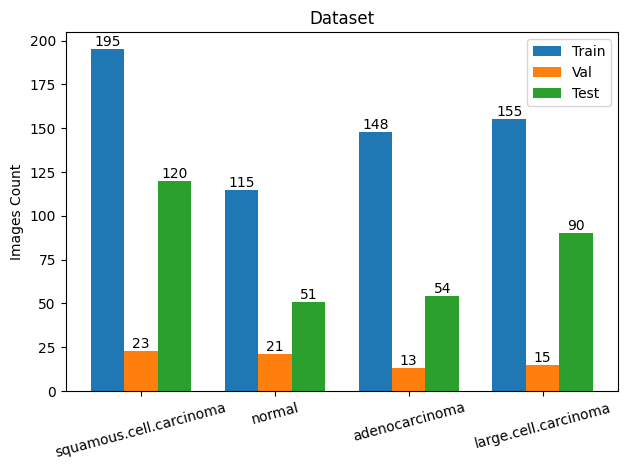

In [5]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [7]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [8]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [9]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [10]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [11]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

# VGG-16

In [12]:
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(350,350,3)
)

In [13]:
NUM_CLASSES = 4

vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 10, 10, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       204,804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,919,492 (56.91 MB)

 Trainable params: 204,804 (800.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [ mc];

In [15]:
# Fitting the Model
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4432 - loss: 2.4860
Epoch 1: val_accuracy improved from None to 0.47143, saving model to ./best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.4984 - loss: 2.1402 - val_accuracy: 0.4714 - val_loss: 2.3065
Epoch 2/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.4000 - loss: 1.9117
Epoch 2: val_accuracy improved from 0.47143 to 0.51429, saving model to ./best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.4000 - loss: 1.9117 - val_accuracy: 0.5143 - val_loss: 1.4612
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5257 - loss: 1.7264
Epoch 3: val_accuracy improved from 0.51429 to 0.54286, saving model to ./best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 2621s 22s/step - accuracy: 0.5329 - loss: 1.9073 - val_accuracy: 0.5429 - val_loss: 1.8320
Epoch 4/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:42 1s/step - accuracy: 0.6000 - loss: 1.0988
Epoch 4: val_accuracy improv

In [16]:
# Loading the Best Fit Model 
model = load_model("./best_model.keras")

In [17]:
# Checking the Accuracy of the Model 
accuracy_vgg = model.evaluate(test_data)[1] 
print(f"The accuracy of the model is = {accuracy_vgg*100} %")

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 637ms/step - accuracy: 0.8127 - loss: 0.8690
The accuracy of the model is = 81.26984238624573 %


In [18]:
vgg.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

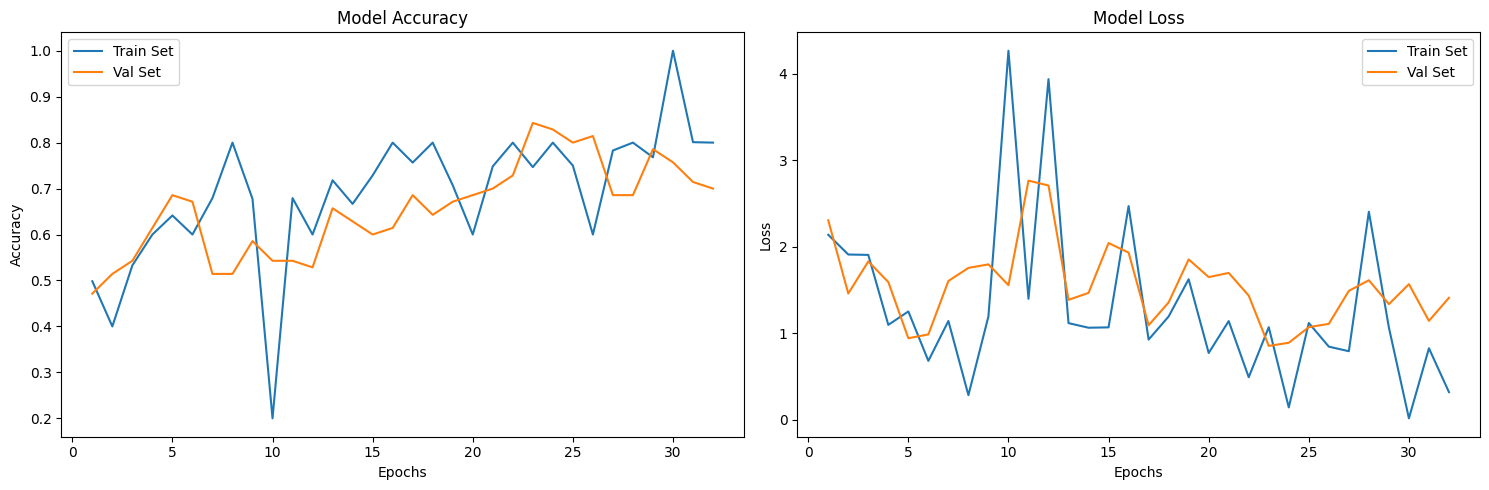

In [19]:
# Plot model performance
acc = vgg.history['accuracy']
val_acc = vgg.history['val_accuracy']
loss = vgg.history['loss']
val_loss = vgg.history['val_loss']
epochs_range = range(1, len(vgg.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()